<a href="https://colab.research.google.com/github/SandeepReddyThippareddy/Activity-Management/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Question - 1

In [65]:
import os
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import re
import sqlite3
import nltk
from nltk.corpus import stopwords
import nltk
from nltk.corpus.reader import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('punkt')
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus.reader import PlaintextCorpusReader

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [66]:
def download_wikipedia_pages_from_file(url_file, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    file_counter = 1
    with open(url_file, 'r') as file:
        urls = file.readlines()

        for url in urls:
            url = url.strip()
            response = requests.get(url)
            if response.status_code == 200:
                title = url.split('/')[-1]
                title = title.split('?')[0]
                file_name = f"{file_counter}_{title}.html"
                file_path = os.path.join(output_directory, file_name)
                with open(file_path, 'w', encoding='utf-8') as file:
                    file.write(response.text)
                file_counter += 1

url_file = 'wiki_233_diseases_sorted_urls.txt'
output_directory = 'wikipedia_html_pages'
download_wikipedia_pages_from_file(url_file, output_directory)

In [67]:
def extract_metadata(html_content):
    metadata = {}
    soup = BeautifulSoup(html_content, 'html.parser')
    json_ld = soup.find('script', type='application/ld+json')
    if json_ld:
        try:
            json_data = json.loads(json_ld.string)
            metadata['name'] = json_data.get('name')
            metadata['url'] = json_data.get('url')
            metadata['datePublished'] = json_data.get('datePublished')
            metadata['dateModified'] = json_data.get('dateModified')
            metadata['headline'] = json_data.get('headline')
        except json.JSONDecodeError as e:
            print(f"Error parsing data: {e}")
    return metadata

In [68]:
def extract_information_from_files(directory):
    data_list = []
    corpus_texts = []
    for filename in os.listdir(directory):
        if filename.endswith(".html"):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                html_content = file.read()
                soup = BeautifulSoup(html_content, 'html.parser')
                title = soup.find('title').get_text()
                main_text = soup.find('div', id='bodyContent').get_text()
                corpus_texts.append(main_text)
                metadata = extract_metadata(html_content)
                metadata['title'] = title
                metadata['text'] = main_text
                data_list.append(metadata)

    corpus_text = '\n'.join(corpus_texts)
    file_name = f"corpus_text.txt"
    with open(file_name, 'w', encoding='utf-8') as file:
        file.write(corpus_text)
    return data_list

In [69]:
directory = 'wikipedia_html_pages'
extracted_data = extract_information_from_files(directory)

In [71]:
articles_df = pd.DataFrame(extracted_data)
articles_df.set_index('title', inplace=True)
articles_without_date_modified = []
for index, row in articles_df.iterrows():
    if pd.isnull(row.get('dateModified')):
        articles_without_date_modified.append(index)
print("Articles without dateModified:")
print(articles_without_date_modified)

Articles without dateModified:
['Dementia - Wikipedia', 'Breast cancer - Wikipedia', 'Myalgic encephalomyelitis/chronic fatigue syndrome - Wikipedia', 'Diabetes - Wikipedia']


In [72]:
sorted_articles_df = articles_df.assign(headline_length=articles_df['headline'].str.len()).sort_values('headline_length')
first_5_rows = sorted_articles_df.head(5)
print(first_5_rows)

                                                name  \
title                                                  
Meningism - Wikipedia                      Meningism   
Hepatomegaly - Wikipedia                Hepatomegaly   
Venous ulcer - Wikipedia                Venous ulcer   
Sleep paralysis - Wikipedia          Sleep paralysis   
Periodontal disease - Wikipedia  Periodontal disease   

                                                                               url  \
title                                                                                
Meningism - Wikipedia                      https://en.wikipedia.org/wiki/Meningism   
Hepatomegaly - Wikipedia                https://en.wikipedia.org/wiki/Hepatomegaly   
Venous ulcer - Wikipedia                https://en.wikipedia.org/wiki/Venous_ulcer   
Sleep paralysis - Wikipedia          https://en.wikipedia.org/wiki/Sleep_paralysis   
Periodontal disease - Wikipedia  https://en.wikipedia.org/wiki/Periodontal_disease   

    

In [73]:
conn = sqlite3.connect('articles.db')
articles_df.to_sql('articles', conn, index_label='title', if_exists='replace')
conn.commit()
conn.close()

Question -2

In [74]:
articles_df.to_csv(r"articles.csv", index=False)

In [75]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
corpus_root = ''
corpus_file = 'corpus_text.txt'
corpus = PlaintextCorpusReader(corpus_root, corpus_file)
raw_text = corpus.raw()
tokenized_sentences = sent_tokenize(raw_text)
word_tokenizer = RegexpTokenizer(r'\w+')
words = [word.lower() for sentence in tokenized_sentences for word in word_tokenizer.tokenize(sentence) if word.lower() not in stop_words]
freq_dist = FreqDist(words)
print(freq_dist.most_common(200))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('10', 19672), ('pmid', 15823), ('doi', 15662), ('1', 9844), ('disease', 9696), ('may', 9049), ('b', 8604), ('j', 7235), ('2', 7219), ('pmc', 6405), ('c', 6214), ('retrieved', 5987), ('3', 5971), ('archived', 5148), ('cancer', 5077), ('4', 5070), ('5', 5006), ('treatment', 4962), ('original', 4910), ('people', 4820), ('journal', 4689), ('edit', 4645), ('s2cid', 4644), ('risk', 4567), ('symptoms', 4169), ('6', 4155), ('syndrome', 3933), ('also', 3912), ('e', 3882), ('health', 3773), ('p', 3593), ('8', 3446), ('9', 3435), ('blood', 3367), ('disorder', 3302), ('review', 3296), ('7', 3266), ('1016', 3240), ('clinical', 3235), ('2015', 3209), ('al', 3152), ('2016', 3152), ('12', 3039), ('g', 3009), ('et', 2940), ('11', 2917), ('medicine', 2879), ('2014', 2865), ('systematic', 2810), ('disorders', 2788), ('infection', 2743), ('2020', 2727), ('cause', 2670), ('cases', 2670), ('children', 2639), ('0', 2607), ('isbn', 2591), ('2017', 2528), ('l', 2522), ('r', 2518), ('2013', 2464), ('march', 2

In [76]:
tokenized_words = [word_tokenizer.tokenize(sentence) for sentence in tokenized_sentences]
all_words = [word.lower() for sentence in tokenized_words for word in sentence]
filtered_words = [word for word in all_words if word not in stop_words and len(word) > 1 and not any(char.isdigit() for char in word)]
word_freq = defaultdict(int)
for word in filtered_words:
    word_freq[word] += 1
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:200]
print(sorted_word_freq[:200])

[('pmid', 15823), ('doi', 15662), ('disease', 9696), ('may', 9049), ('pmc', 6405), ('retrieved', 5987), ('archived', 5148), ('cancer', 5077), ('treatment', 4962), ('original', 4910), ('people', 4820), ('journal', 4689), ('edit', 4645), ('risk', 4567), ('symptoms', 4169), ('syndrome', 3933), ('also', 3912), ('health', 3773), ('blood', 3367), ('disorder', 3302), ('review', 3296), ('clinical', 3235), ('al', 3152), ('et', 2940), ('medicine', 2879), ('systematic', 2810), ('disorders', 2788), ('infection', 2743), ('cause', 2670), ('cases', 2670), ('children', 2639), ('isbn', 2591), ('march', 2452), ('diagnosis', 2441), ('january', 2432), ('common', 2422), ('associated', 2355), ('american', 2329), ('virus', 2301), ('december', 2298), ('october', 2289), ('one', 2285), ('june', 2285), ('therapy', 2276), ('february', 2247), ('medical', 2244), ('april', 2234), ('cell', 2231), ('august', 2223), ('diseases', 2204), ('use', 2199), ('used', 2176), ('july', 2140), ('september', 2126), ('november', 211

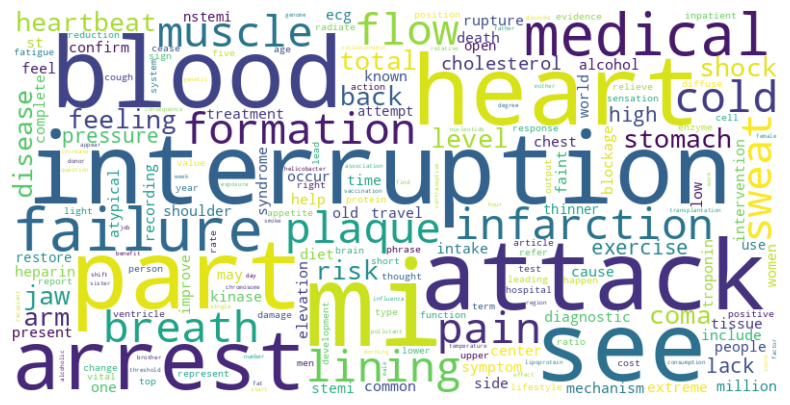

In [94]:
wordcloud_text = ' '.join(word for word in word_freq.keys())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Question - 3

In [78]:
conn = sqlite3.connect('articles.db')
loaded_articles_df = pd.read_sql_query("SELECT * FROM articles", conn)
print(loaded_articles_df.head())
print(loaded_articles_df.columns)
print(len(loaded_articles_df))

                               title                   name  \
0  Myocardial infarction - Wikipedia  Myocardial infarction   
1   Gestational diabetes - Wikipedia   Gestational diabetes   
2           Hepatomegaly - Wikipedia           Hepatomegaly   
3               Syphilis - Wikipedia               Syphilis   
4         Chagas disease - Wikipedia         Chagas disease   

                                                 url         datePublished  \
0  https://en.wikipedia.org/wiki/Myocardial_infar...  2002-07-07T23:38:32Z   
1  https://en.wikipedia.org/wiki/Gestational_diab...  2004-06-02T02:55:25Z   
2         https://en.wikipedia.org/wiki/Hepatomegaly  2005-02-12T11:21:09Z   
3             https://en.wikipedia.org/wiki/Syphilis  2001-11-09T12:02:51Z   
4       https://en.wikipedia.org/wiki/Chagas_disease  2001-11-05T16:31:23Z   

           dateModified                                           headline  \
0  2024-01-16T12:25:15Z  interruption of blood supply to a part of the ...

In [79]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def tokenize(text):
   return re.findall(r'[A-Za-z]+', text)
def remove_stop(tokens):
   return [t for t in tokens if t.lower() not in stop_words]
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}
stop_words |= include_stopwords
stop_words -= exclude_stopwords
pipeline = [str.lower, tokenize, remove_stop]
def prepare(text, pipeline):
   tokens = text
   for transform in pipeline:
       tokens = transform(tokens)
   return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
articles_df['tokens'] = articles_df['text'].apply(prepare, pipeline=pipeline)

In [81]:
articles_df['num_tokens'] = articles_df['tokens'].apply(len)

In [82]:
articles_df.head()

,name,url,datePublished,dateModified,headline,text,tokens,num_tokens
title,,,,,,,,
Myocardial infarction - Wikipedia,Myocardial infarction,https://en.wikipedia.org/wiki/Myocardial_infar...,2002-07-07T23:38:32Z,2024-01-16T12:25:15Z,interruption of blood supply to a part of the ...,"\n\n\n\n\n\nFrom Wikipedia, the free encyclope...","[wikipedia, free, encyclopedia, interruption, ...",9287
Gestational diabetes - Wikipedia,Gestational diabetes,https://en.wikipedia.org/wiki/Gestational_diab...,2004-06-02T02:55:25Z,2024-01-08T09:05:30Z,condition in which a woman without diabetes de...,"\n\n\n\nFrom Wikipedia, the free encyclopedia\...","[wikipedia, free, encyclopedia, medical, condi...",6595
Hepatomegaly - Wikipedia,Hepatomegaly,https://en.wikipedia.org/wiki/Hepatomegaly,2005-02-12T11:21:09Z,2023-12-11T00:28:52Z,symptom,"\n\n\n\nFrom Wikipedia, the free encyclopedia\...","[wikipedia, free, encyclopedia, medical, condi...",1314
Syphilis - Wikipedia,Syphilis,https://en.wikipedia.org/wiki/Syphilis,2001-11-09T12:02:51Z,2024-01-19T17:13:11Z,sexually transmitted infection,"\n\n\n\n\n\nFrom Wikipedia, the free encyclope...","[wikipedia, free, encyclopedia, sexually, tran...",7500
Chagas disease - Wikipedia,Chagas disease,https://en.wikipedia.org/wiki/Chagas_disease,2001-11-05T16:31:23Z,2024-01-14T12:34:15Z,human disease,"\n\n\n\n\nFrom Wikipedia, the free encyclopedi...","[wikipedia, free, encyclopedia, mammal, parasi...",4728


In [83]:
from collections import Counter
def count_words(df, column='tokens', preprocess=None, min_freq=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    counter = Counter()
    df[column].apply(update)
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

In [84]:
freq_articles_df = count_words(articles_df)

In [85]:
freq_articles_df.head()

,freq
token,
pmid,15823
doi,15662
disease,9717
b,9490
may,9052


In [87]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))
    counter = Counter()
    df[column].apply(update)
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [88]:
idf_articles_df = compute_idf(articles_df)

<ipython-input-87-05314042cae3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


In [89]:
idf_articles_df.head()

,df,idf
token,,
improved,101,0.935918
outweigh,14,2.911981
recurrence,50,1.639015
hopkins,40,1.862159
contribute,93,1.018439


In [90]:
freq_articles_df = freq_articles_df.join(idf_articles_df, how='left')

In [91]:
freq_articles_df['tfidf'] = freq_articles_df['freq'] * freq_articles_df['idf']

In [92]:
sorted_freq_articles_df = freq_articles_df.sort_values('tfidf', ascending=False)

In [93]:
sorted_freq_articles_df.head(10)

,freq,df,idf,tfidf
token,,,,
cancer,5089,126.0,0.714757,3637.396066
virus,2301,94.0,1.007744,2318.818188
disorder,3314,137.0,0.631058,2091.324647
autism,877,34.0,2.024678,1775.642544
pmid,15823,231.0,0.108621,1718.706017
doi,15662,231.0,0.108621,1701.218078
malaria,818,33.0,2.054531,1680.606270
diabetes,1994,113.0,0.823651,1642.359366
sleep,1669,100.0,0.945868,1578.654139


from matplotlib import pyplot as plt
_df_2['freq'].plot(kind='hist', bins=20, title='freq')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['df'].plot(kind='hist', bins=20, title='df')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['idf'].plot(kind='hist', bins=20, title='idf')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['tfidf'].plot(kind='hist', bins=20, title='tfidf')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='freq', y='df', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='df', y='idf', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='idf', y='tfidf', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9['freq'].plot(kind='line', figsize=(8, 4), title='freq')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['df'].plot(kind='line', figsize=(8, 4), title='df')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['idf'].plot(kind='line', figsize=(8, 4), title='idf')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['tfidf'].plot(kind='line', figsize=(8, 4), title='tfidf')
plt.gca().spines[['top', 'right']].set_visible(False)

The first 10 entries of the filtered list from 2b represent the most frequently occurring words in the corpus. These words are based solely on their frequency of occurrence, without considering their importance or uniqueness in the corpus.

On the other hand, the resulting rows after calculating TFIDF incorporate not only the frequency of each word but also their importance in the entire corpus. The TFIDF (Term Frequency-Inverse Document Frequency) metric considers both the frequency of the term in the corpus and the uniqueness of the term across different documents. This means that the TFIDF values provide a measure of how important each term is in the corpus relative to each document.

The TFIDF values provide a more meaningful representation of the words by accounting for their significance in the corpus, unlike the simple frequency-based approach. Therefore, the returned rows after calculating TFIDF are more meaningful as they take into account the uniqueness and importance of the terms, providing a better understanding of their significance in the corpus.